# Powerlifting Data Visualization

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

## Scale factors
Constants used to project 1RM (one rep max) for different rep ranges from 1-10

In [44]:
scale_factors = {1:1,2:.96,3:.92,4:.89,5:.87,6:.84,7:.81,8:.79,9:.76,10:.74}

In [45]:
df = pd.read_csv('../data/WorkoutExport.csv')

## Filtering dataset

In [46]:
df = df[df['isWarmup'] == False] # Remove warm-up sets
df = df[(df['Reps'] < 11) & (df['Reps'] > 0)] # Keep only data with reps 1-10
df['Weight(lbs)'] = df['Weight(kg)'] * 2.20462 # Convert weight to lbs

# Add a column to dataframe containing projected 1RM for each row in data
scale_columns = [scale_factors[reps] for reps in df['Reps']] 
df['1RM'] = df['Weight(lbs)']/scale_columns

# Convert Date column to datetime
df['Date'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S %z') for d in df['Date']]
# 2020-07-15 00:10:55 +0000
df = df[['Date', 'Exercise', 'Reps', 'Weight(lbs)', '1RM']] # Select only relevant columns

In [47]:
# Keep only rows with highest 1RM for each exercise for each date
grouped = df.groupby(by = ['Date','Exercise'])
df = df[df['1RM'] == (grouped.transform('max')['1RM'])]
df = df.drop_duplicates()

# Create dataframes for each exercise

In [48]:
df_squat = df[(df['Exercise'] == 'Back Squat') & (df['Weight(lbs)'] > 186)] # remove additional warm-up sets
# print(df_squat.to_string())

In [49]:
df_bench = df[df['Exercise'] == 'Barbell Bench Press']
print(df_bench.to_string())

                          Date             Exercise  Reps  Weight(lbs)         1RM
16   2020-07-10 20:40:13+00:00  Barbell Bench Press   5.0        205.0  235.632184
113  2020-07-07 16:23:00+00:00  Barbell Bench Press   1.0        245.0  245.000000
172  2020-07-03 22:04:00+00:00  Barbell Bench Press  10.0        165.0  222.972973
249  2020-06-30 22:38:00+00:00  Barbell Bench Press   3.0        225.0  244.565217
254  2020-06-30 00:02:25+00:00  Barbell Bench Press  10.0        140.0  189.189189
286  2020-06-27 04:51:00+00:00  Barbell Bench Press   1.0        225.0  225.000000
300  2020-06-24 03:36:00+00:00  Barbell Bench Press   8.0        165.0  208.860759
354  2020-06-19 21:54:00+00:00  Barbell Bench Press   4.0        205.0  230.337079
435  2020-06-16 22:38:00+00:00  Barbell Bench Press   7.0        175.0  216.049383
535  2020-06-12 10:00:00+00:00  Barbell Bench Press   8.0        185.0  234.177215
584  2020-06-11 06:17:00+00:00  Barbell Bench Press   8.0        185.0  234.177215
592 

In [50]:
df_deadlift = df[(df['Exercise'] == 'Deadlift') & (df['Weight(lbs)'] > 186)]
# print(df_deadlift.to_string())

In [51]:
df_sumo_deadlift = df[(df['Exercise'] == 'Sumo Deadlift') & (df['Weight(lbs)'] > 186)]
# print(df_sumo_deadlift.to_string())

## Visualizing data with matplotlib

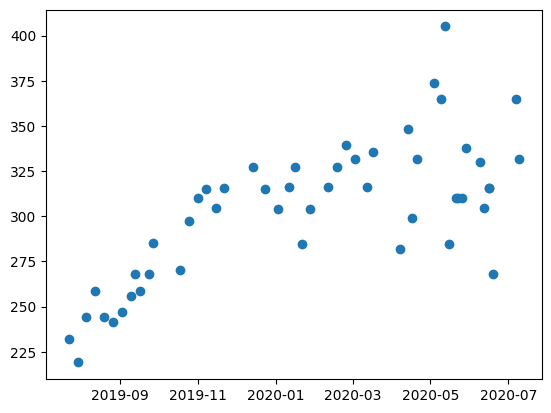

In [52]:
plt.scatter(df_squat['Date'], df_squat['1RM'])

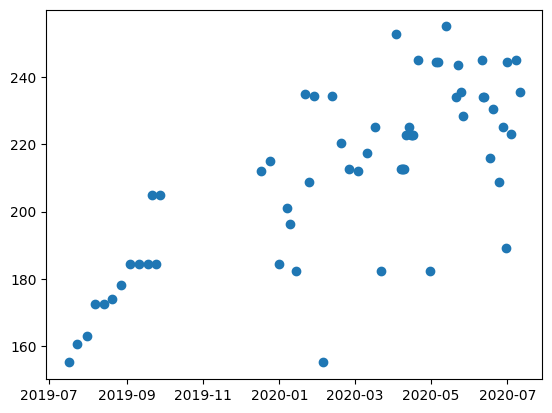

In [53]:
plt.scatter(df_bench['Date'], df_bench['1RM'])

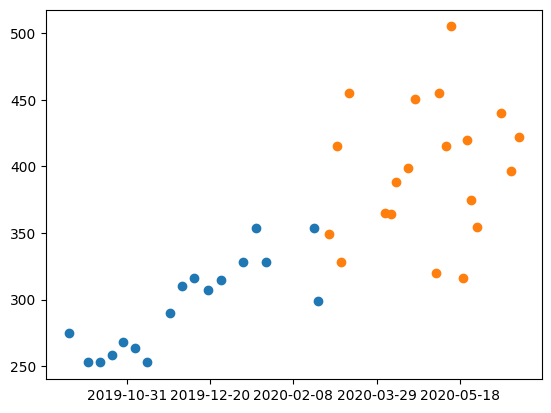

In [60]:
fig, ax = plt.subplots()
ax.scatter(df_deadlift['Date'], df_deadlift['1RM'])
ax.scatter(df_sumo_deadlift['Date'], df_sumo_deadlift['1RM'])

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

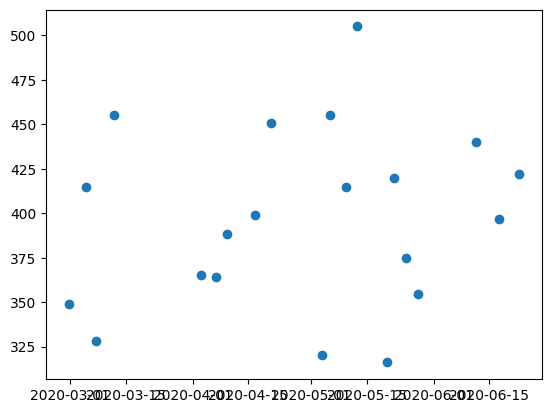